In [3]:
import numpy as np
import pandas as pd
import statistics
import scipy.stats as ss
import matplotlib.pyplot as plt
import arch
from arch import arch_model


In [6]:
# Load the data from the second sheet
file_path = "Data_v2_2024.06.11 - Copy.xlsx"
df = pd.read_excel(file_path, sheet_name=1, header=[2])
df.head()


,Security,GDBR10 Date,GDBR10 Index,GTFRF10Y Date,GTFRF10Y Govt,GTNLG10Y Date,GTNLG10Y Govt,GTATS10Y Date,GTATS10Y Govt,GTFIM10Y Date,...,Unnamed: 36,GBTPGR10 Date.1,Unnamed: 38,GTESP10Y Date.1,Unnamed: 40,GTPTE10Y Date.1,Unnamed: 42,GIGB10YR Date.1,Unnamed: 44,USGG10YR Date.1
0,NaN,2000-01-03,5.478,2000-01-03,5.593,2000-01-03,5.612,2000-01-03,5.681,2000-01-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2000-01-04,5.492,2000-01-04,5.611,2000-01-04,5.631,2000-01-04,5.699,2000-01-04,...,NaN,NaN,NaN,NaN,NaN,1 Missing date(s),NaN,NaN,NaN,NaN
2,NaN,2000-01-05,5.516,2000-01-05,5.643,2000-01-05,5.646,2000-01-05,5.722,2000-01-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2000-01-06,5.545,2000-01-06,5.678,2000-01-06,5.710,2000-01-06,5.776,2000-01-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2000-01-07,5.443,2000-01-07,5.567,2000-01-07,5.609,2000-01-07,5.681,2000-01-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
EA_yields_daily = pd.read_excel(file_path, sheet_name=2, header=[14], usecols=[1,12])
EA_yields_daily.rename(columns={'DATE': 'EA10Y Date', 'Par yield curve rate, 10-year maturity - Government bond, nominal, all issuers all ratings included - Euro area (changing composition) (YC.B.U2.EUR.4F.G_N_C.SV_C_YM.PY_10Y)': 'EA10Y Yield'}, inplace=True)
EA_yields_daily.head()

,EA10Y Date,EA10Y Yield
0,2004-09-06,4.156516
1,2004-09-07,4.157714
2,2004-09-08,4.178160
3,2004-09-09,4.113731
4,2004-09-10,4.071960


In [64]:
# Extract columns for each country
countries = ['GDBR10', 'GTFRF10Y', 'GTNLG10Y', 'GTATS10Y', 'GTFIM10Y', 'GTBEF10Y', 'GBTPGR10', 'GTESP10Y', 'GTPTE10Y', 'GIGB10YR', 'USGG10YR']
date_columns = [f'{country} Date' for country in countries]
yield_columns = [col for col in df.columns if 'Govt' in col or 'Index' in col]

# Create a new DataFrame for processing
data = pd.DataFrame()

for date_col, yield_col in zip(date_columns, yield_columns):
    temp_df = df[[date_col, yield_col]].dropna()
    temp_df.columns = ['Date', 'Bond_Yield']
    temp_df['Country'] = yield_col.split()[0]
    temp_df['Date'] = pd.to_datetime(temp_df['Date'])
    data = pd.concat([data, temp_df])

data = data.set_index(['Country', 'Date'])

In [65]:
data

Bond_Yield
Country  Date                  
GDBR10   2000-01-03      5.4780
         2000-01-04      5.4920
         2000-01-05      5.5160
         2000-01-06      5.5450
         2000-01-07      5.4430
...                         ...
USGG10YR 2024-05-20      4.4433
         2024-05-21      4.4120
         2024-05-22      4.4218
         2024-05-23      4.4767
         2024-05-24      4.4650

[69149 rows x 1 columns]

In [ ]:
# Assuming the new data is in a similar format
new_country_code = 'EA10Y'  # Replace with the actual country code
new_date_column = f'{new_country_code} Date'
new_yield_column = f'{new_country_code} Yield'  # Replace with the actual yield column name
# Process the new data
new_data = EA_yields_daily[[new_date_column, new_yield_column]].dropna()
new_data.columns = ['Date', 'Bond_Yield']
new_data['Country'] = new_country_code
new_data['Date'] = pd.to_datetime(new_data['Date'])
new_data = new_data.set_index(['Country', 'Date'])
new_data

In [112]:
# Add the new country to the list of countries
countries.append(new_country_code)

# Combine the new data with the existing data
data = pd.concat([data, new_data])
data

Bond_Yield
Country Date                  
GDBR10  2000-01-03    5.478000
        2000-01-04    5.492000
        2000-01-05    5.516000
        2000-01-06    5.545000
        2000-01-07    5.443000
...                        ...
EA10Y   2024-06-03    3.160845
        2024-06-04    3.090801
        2024-06-05    3.075257
        2024-06-06    3.132258
        2024-06-07    3.197658

[74200 rows x 1 columns]

Calculating Volatilities

In [113]:
# Calculate monthly volatility as the standard deviation of daily yields within each month
monthly_vol_std = data['Bond_Yield'].groupby(level=0).resample('M', level=1).std()
monthly_vol_std

Country   Date      
EA10Y     2004-09-30    0.065799
          2004-10-31    0.059791
          2004-11-30    0.065688
          2004-12-31    0.068739
          2005-01-31    0.044199
                          ...   
USGG10YR  2024-01-31    0.086972
          2024-02-29    0.110370
          2024-03-31    0.074473
          2024-04-30    0.132811
          2024-05-31    0.067142
Name: Bond_Yield, Length: 3461, dtype: float64

In [31]:
# Function to fit GARCH model and get the monthly volatility
def garch_volatility(yields):
    if len(yields.dropna()) > 1:
        scaled_yields = yields.dropna() * 1000  # Rescaling yields
        model = arch_model(scaled_yields, vol='Garch', p=1, q=1, rescale=False)
        model_fitted = model.fit(disp='off')
        return model_fitted.conditional_volatility[-1] / 1000  # Rescaling back
    else:
        return None

In [114]:


# Calculate GARCH volatility for each country
garch_results = []
for country in data.index.levels[0]:
    country_data = data.loc[country]['Bond_Yield']
    garch_vol = country_data.resample('M').apply(garch_volatility)
    garch_vol.name = country
    garch_results.append(garch_vol)

monthly_vol_garch = pd.concat(garch_results, axis=1).stack().reset_index()
monthly_vol_garch.columns = ['Date', 'Country', 'GARCH']
monthly_vol_garch = monthly_vol_garch.set_index(['Country', 'Date'])


In [115]:
monthly_vol_garch

,,GARCH
Country,Date,
GBTPGR10,2000-01-31,0.063593
GDBR10,2000-01-31,0.056910
GIGB10YR,2000-01-31,0.052606
GTATS10Y,2000-01-31,0.061712
GTBEF10Y,2000-01-31,0.089576
...,...,...
GTFRF10Y,2024-05-31,0.064791
GTNLG10Y,2024-05-31,0.069560
GTPTE10Y,2024-05-31,0.067361


In [116]:
# Define the lambda parameter for EWMA
lambda_ewma = 0.94

# Calculate EWMA volatility
ewma_volatility = data['Bond_Yield'].groupby(level=0).apply(lambda x: x.ewm(span=30).std())

# Resample to get monthly data
monthly_vol_ewma = ewma_volatility.groupby(level=0).resample('M', level=1).last()
monthly_vol_ewma


Country   Date      
EA10Y     2004-09-30    0.060791
          2004-10-31    0.070384
          2004-11-30    0.082257
          2004-12-31    0.114092
          2005-01-31    0.084148
                          ...   
USGG10YR  2024-01-31    0.154252
          2024-02-29    0.133300
          2024-03-31    0.087963
          2024-04-30    0.192000
          2024-05-31    0.117564
Name: Bond_Yield, Length: 3461, dtype: float64

In [117]:
# Combine all volatilities into one DataFrame
vol_df_std = monthly_vol_std.reset_index().rename(columns={'Bond_Yield': 'Standard_Deviation'})
vol_df_garch = monthly_vol_garch.reset_index()
vol_df_ewma = monthly_vol_ewma.reset_index().rename(columns={'Bond_Yield': 'EWMA'})

# Merge the DataFrames on 'Country' and 'Date'
vol_df = vol_df_std.merge(vol_df_garch, on=['Country', 'Date'], how='outer').merge(vol_df_ewma, on=['Country', 'Date'], how='outer')

# Display the combined DataFrame
print(vol_df.head())


  Country       Date  Standard_Deviation     GARCH      EWMA
0   EA10Y 2004-09-30            0.065799  0.061914  0.060791
1   EA10Y 2004-10-31            0.059791  0.032196  0.070384
2   EA10Y 2004-11-30            0.065688  0.017799  0.082257
3   EA10Y 2004-12-31            0.068739  0.072458  0.114092
4   EA10Y 2005-01-31            0.044199  0.032272  0.084148


In [118]:
vol_df.to_excel("merged_volatilities.xlsx")

In [119]:
# First, make sure each dataframe has the correct structure and naming
vol_df_std.columns = ['Country', 'Date', 'Standard_Deviation']
vol_df_garch.columns = ['Country', 'Date', 'GARCH']
vol_df_ewma.columns = ['Country', 'Date', 'EWMA']

# Merge the DataFrames on 'Country' and 'Date'
vol_df_combined = vol_df_std.merge(vol_df_garch, on=['Country', 'Date'], how='outer').merge(vol_df_ewma, on=['Country', 'Date'], how='outer')

# Pivot the combined DataFrame to get the desired format
vol_df_pivot = vol_df_combined.pivot_table(index='Date', columns='Country', values=['Standard_Deviation', 'GARCH', 'EWMA'])

# Flatten the MultiIndex columns
vol_df_pivot.columns = ['_'.join(col).strip() for col in vol_df_pivot.columns.values]

# Reorder columns to group by country
ordered_columns = []
for country in countries:
    ordered_columns.extend([f'Standard_Deviation_{country}', f'GARCH_{country}', f'EWMA_{country}'])
vol_df_pivot = vol_df_pivot[ordered_columns]

# Display the final DataFrame
print(vol_df_pivot.head())



            Standard_Deviation_GDBR10  GARCH_GDBR10  EWMA_GDBR10  \
Date                                                               
2000-01-31                   0.058494      0.056910     0.055745   
2000-02-29                   0.061954      0.056009     0.065550   
2000-03-31                   0.096706      0.059890     0.118035   
2000-04-30                   0.059081      0.080600     0.086842   
2000-05-31                   0.073465      0.136777     0.083937   

            Standard_Deviation_GTFRF10Y  GARCH_GTFRF10Y  EWMA_GTFRF10Y  \
Date                                                                     
2000-01-31                     0.057951        0.056194       0.054531   
2000-02-29                     0.057936        0.061310       0.061254   
2000-03-31                     0.096731        0.059941       0.119203   
2000-04-30                     0.055980        0.054775       0.087144   
2000-05-31                     0.077129        0.108191       0.091319   

    

In [121]:
vol_df_pivot.to_excel("pivot_merged_volatilities.xlsx")

In [85]:
df2 = pd.read_excel(file_path, sheet_name=0, header=[2])
df2 = df2.drop(df2.iloc[:, 11:], axis = 1)
# Define the maturity labels and country codes
maturity_labels2 = ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y']
country_codes2 = ['EA'] + ['DE', 'FR', 'NL', 'AT', 'FI', 'BE', 'IT', 'ES', 'PT', 'GB', 'US']

# Rename the unnamed columns for the Euro Area
for i in range(1, 11):
    df2.rename(columns={f'Unnamed: {i}': f'EA_{maturity_labels2[i-1]}'}, inplace=True)
df2.set_index('Security', inplace=True)
df2.index = pd.to_datetime(df2.index)

df2

,EA_1Y,EA_2Y,EA_3Y,EA_4Y,EA_5Y,EA_6Y,EA_7Y,EA_8Y,EA_9Y,EA_10Y
Security,,,,,,,,,,
2000-01-31,4.238960,4.581320,4.866830,5.100040,5.282600,5.382660,5.530220,5.645347,5.699073,5.750700
2000-02-29,4.252000,4.606800,4.903550,5.110700,5.225400,5.375800,5.509000,5.607400,5.684600,5.719000
2000-03-31,4.339390,4.553780,4.761170,4.924760,5.054000,5.172990,5.273080,5.338053,5.390427,5.424600
2000-04-30,4.540180,4.740860,4.936740,5.090620,5.191950,5.298580,5.371760,5.430173,5.469287,5.503800
2000-05-31,4.962170,5.074440,5.176510,5.244980,5.285900,5.348670,5.394540,5.425560,5.440080,5.445600
...,...,...,...,...,...,...,...,...,...,...
2023-12-31,3.095112,2.595478,2.412045,2.381430,2.420318,2.487021,2.561340,2.633996,2.701132,2.761506
2024-01-31,3.154288,2.681122,2.509892,2.485573,2.528428,2.598203,2.675209,2.750312,2.819672,2.882031
2024-02-29,3.418721,3.072456,2.910273,2.850803,2.847246,2.872776,2.912160,2.956870,3.002245,3.045829


In [90]:
EA_yields_daily2 = pd.read_excel(file_path, sheet_name=2, header=[14], usecols=[1,4])
EA_yields_daily2.rename(columns={'DATE': 'Date', 'Par yield curve rate, 2-year maturity - Government bond, nominal, all issuers all ratings included - Euro area (changing composition) (YC.B.U2.EUR.4F.G_N_C.SV_C_YM.PY_2Y)': 'EA2Y Yield'}, inplace=True)
EA_yields_daily2.set_index('Date', inplace=True)
EA_yields_daily2.index = pd.to_datetime(EA_yields_daily2.index)
EA_yields_daily2 = EA_yields_daily2/100
EA_yields_daily2.head()

,EA2Y Yield
Date,
2004-09-06,0.026521
2004-09-07,0.026892
2004-09-08,0.027160
2004-09-09,0.026546
2004-09-10,0.025988


In [92]:
EA_2y_garch_vols = []

garch_vol2y = EA_yields_daily2.resample('M').apply(garch_volatility)
garch_vol2y.name = 'Vol'
EA_2y_garch_vols.append(garch_vol2y)
EA_2y_garch_vols = pd.DataFrame(EA_2y_garch_vols[0])
EA_2y_garch_vols

,EA2Y Yield
Date,
2004-09-30,0.000335
2004-10-31,0.000383
2004-11-30,0.000497
2004-12-31,0.000792
2005-01-31,0.000184
...,...
2024-02-29,0.001080
2024-03-31,0.000312
2024-04-30,0.000868


In [93]:
%store EA_2y_garch_vols

Stored 'EA_2y_garch_vols' (DataFrame)


---

# Normal Tests

In [132]:
import seaborn as sns
from scipy.stats import shapiro, kstest, norm, probplot

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


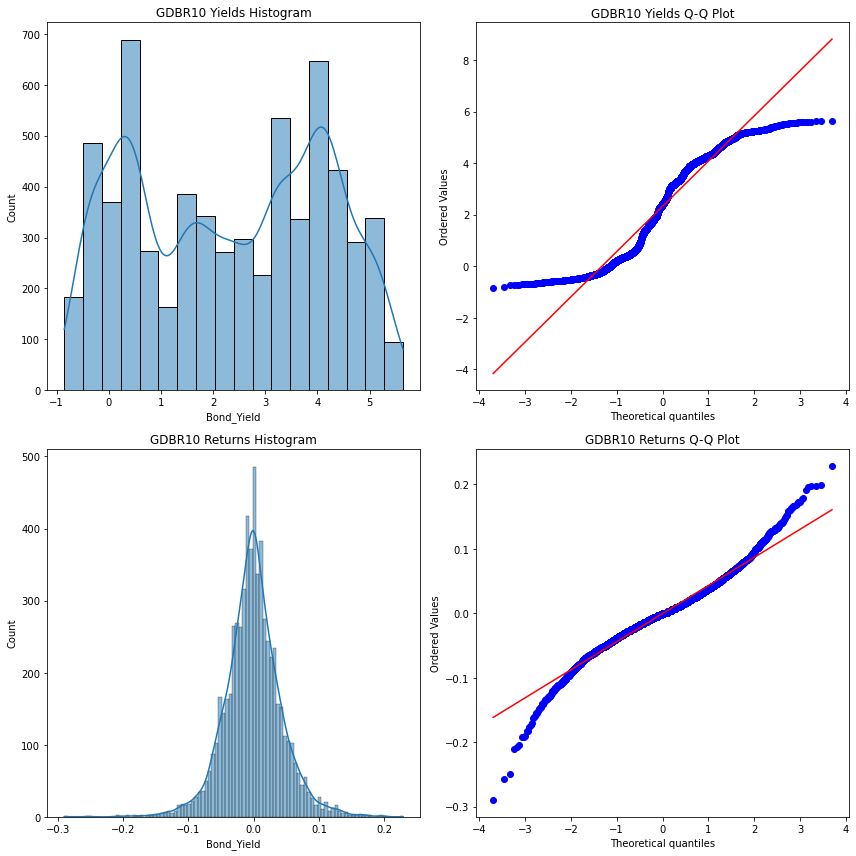

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


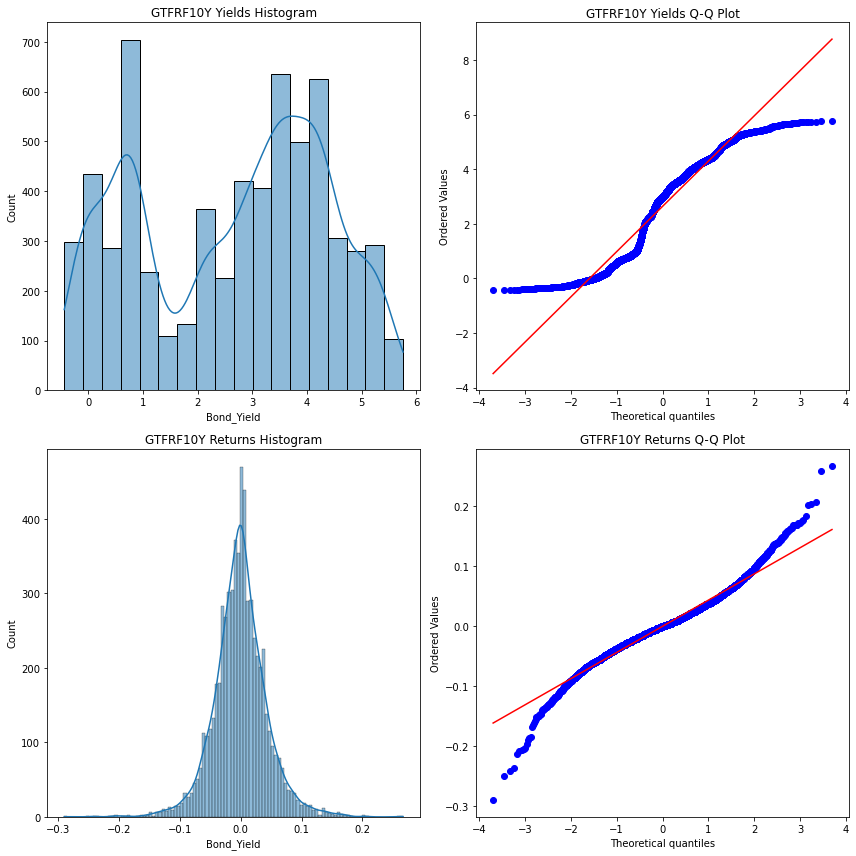

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


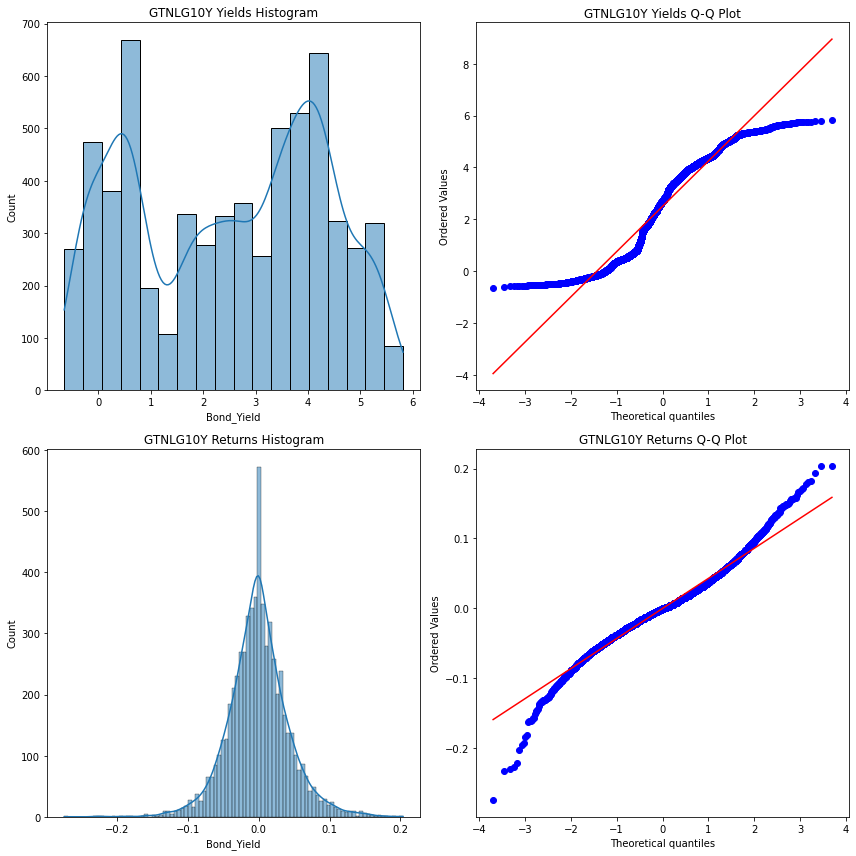

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


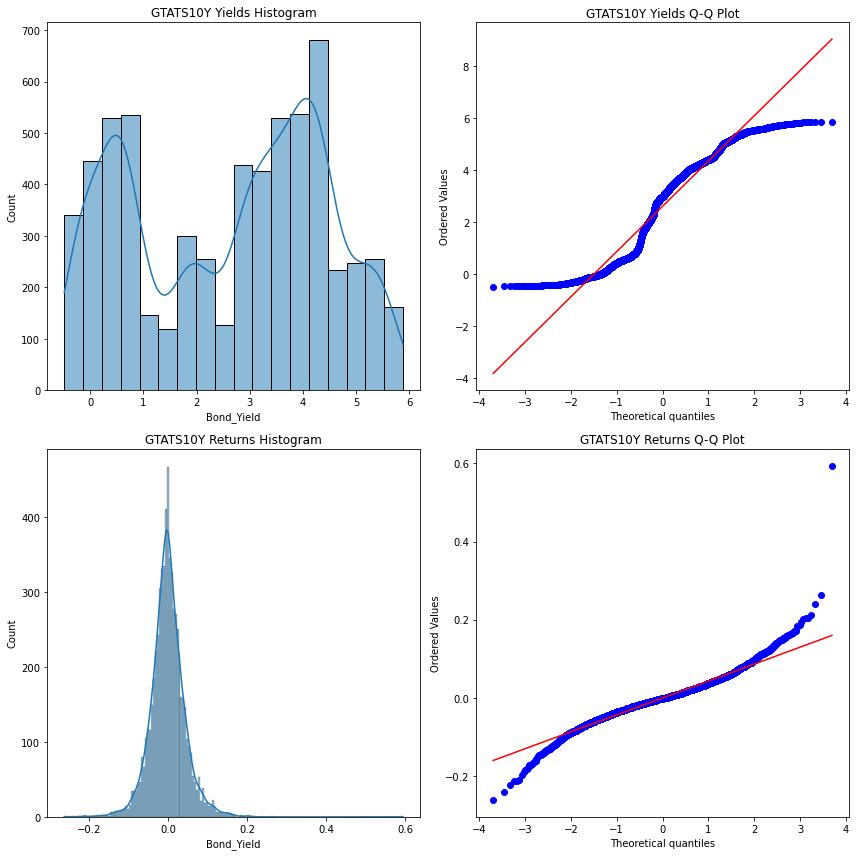

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


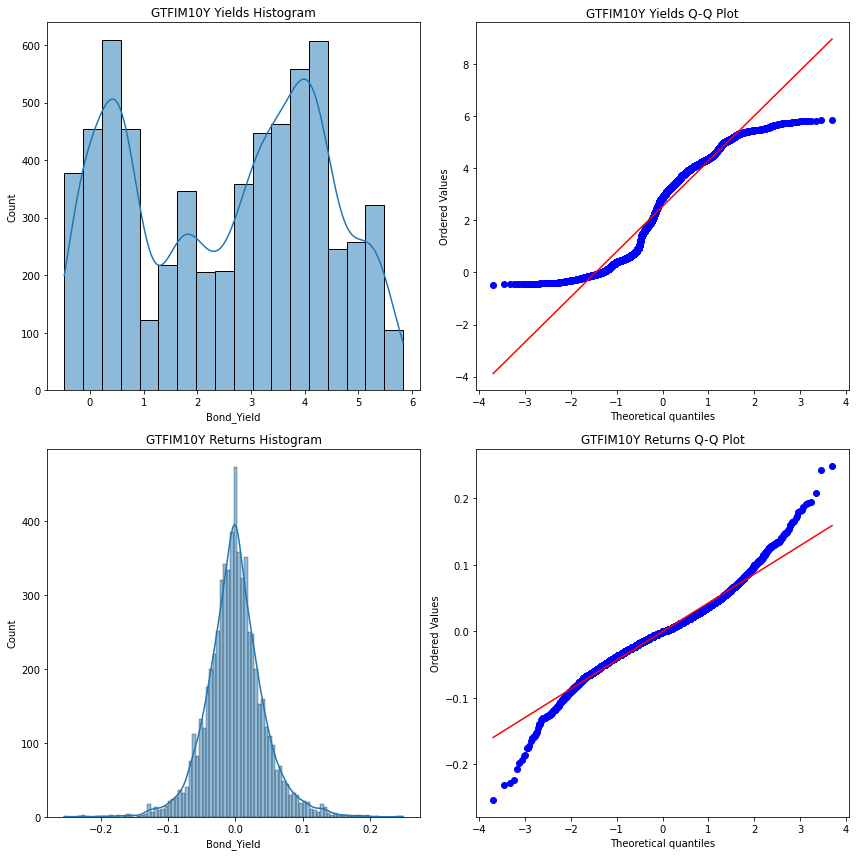

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


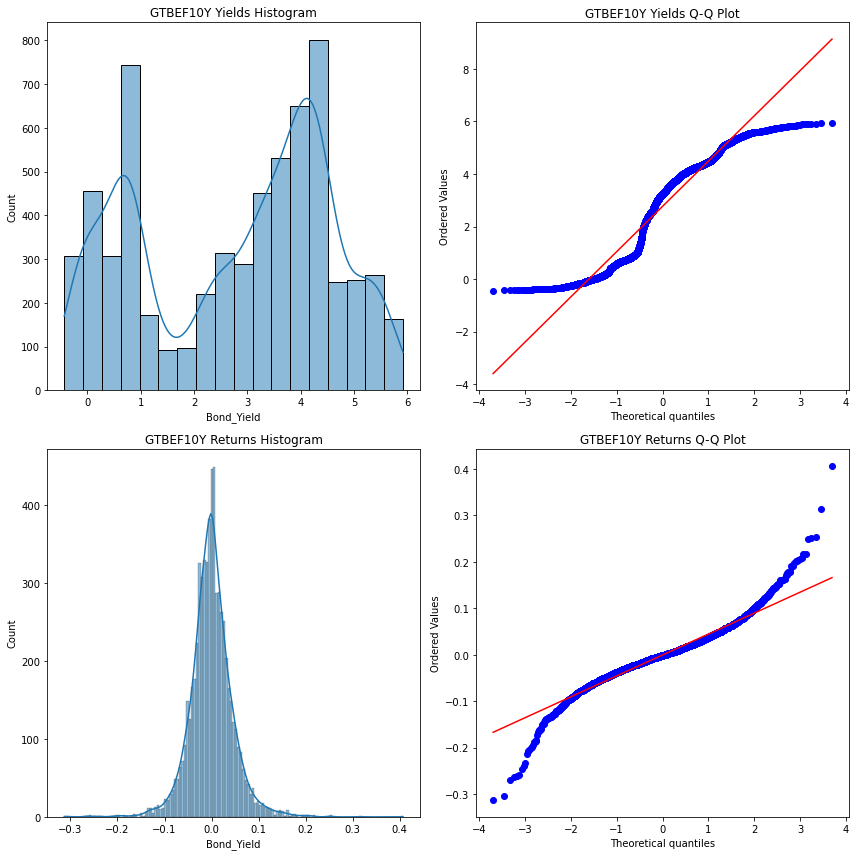

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


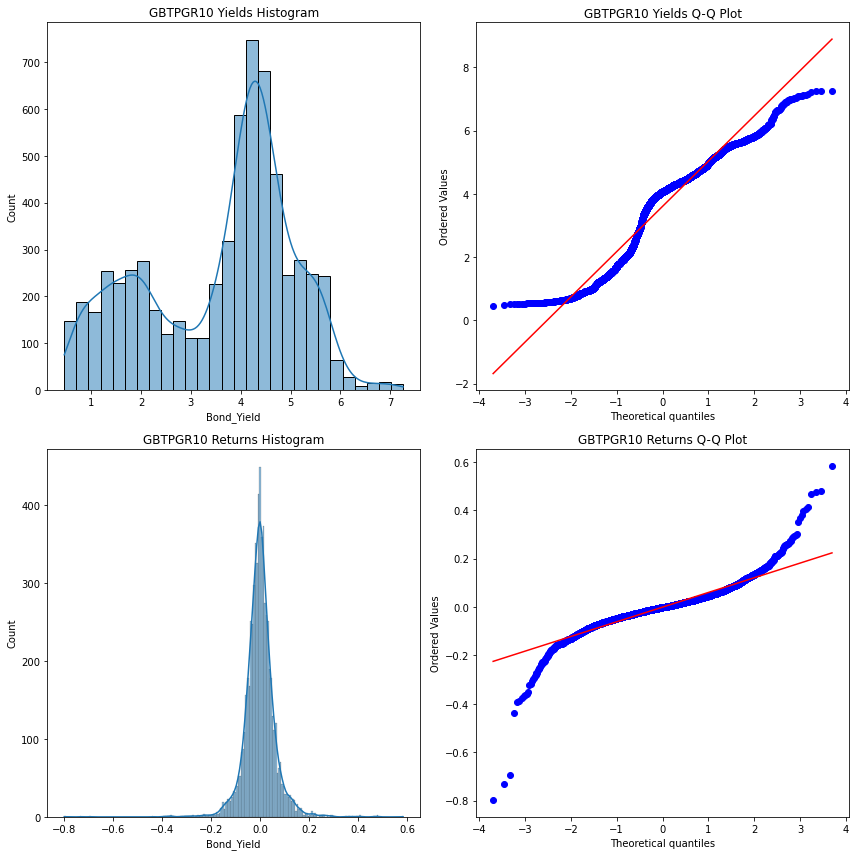

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


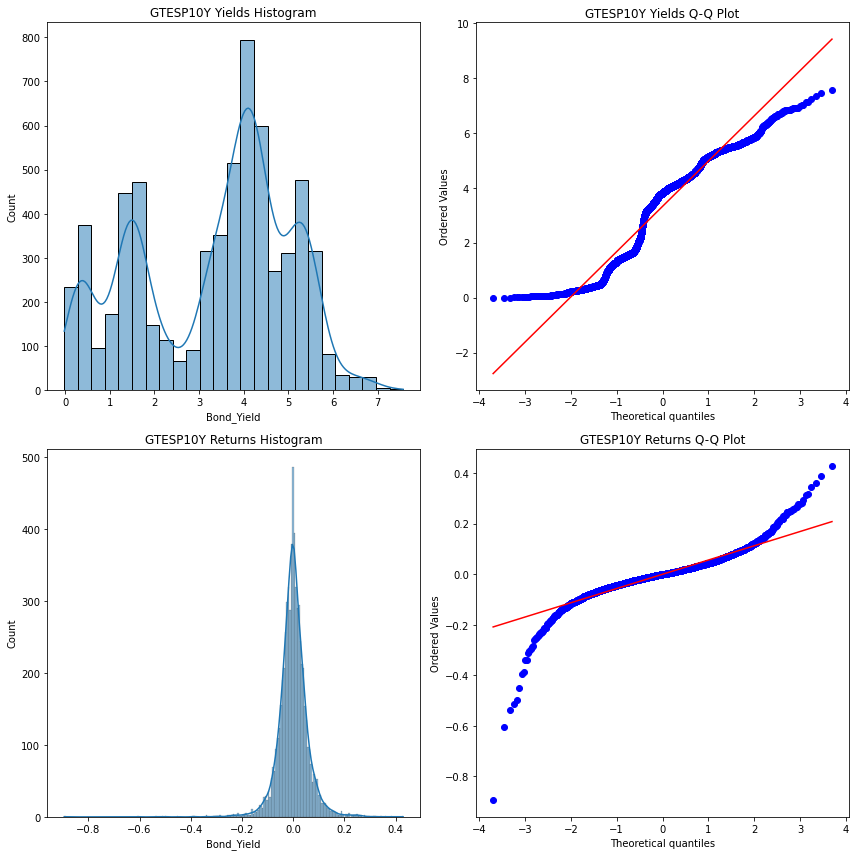

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


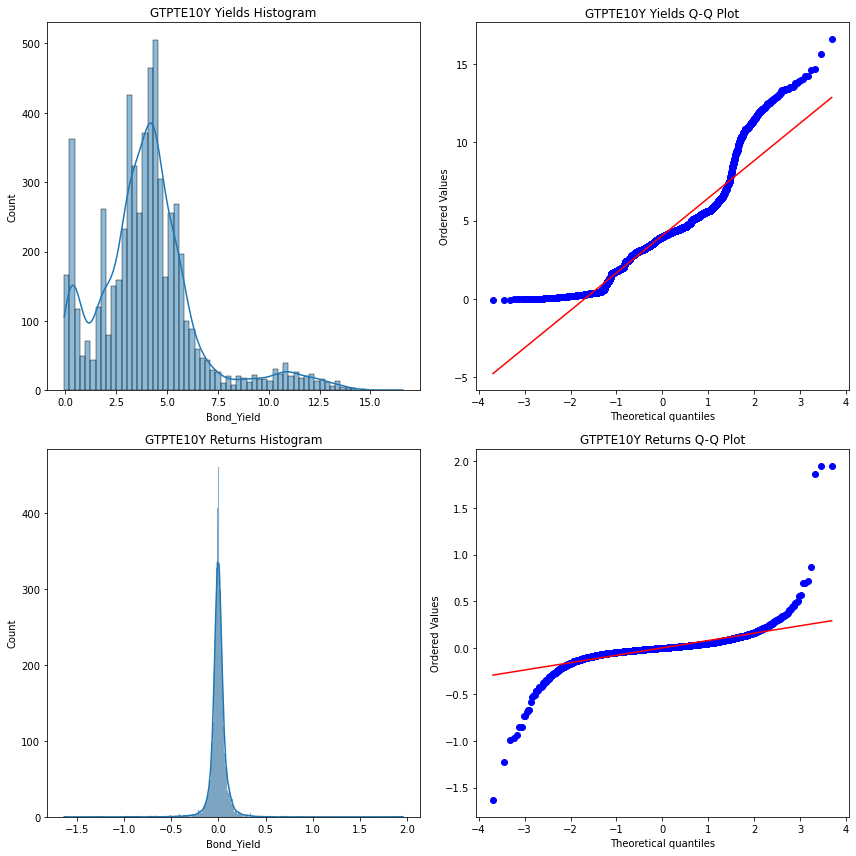

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


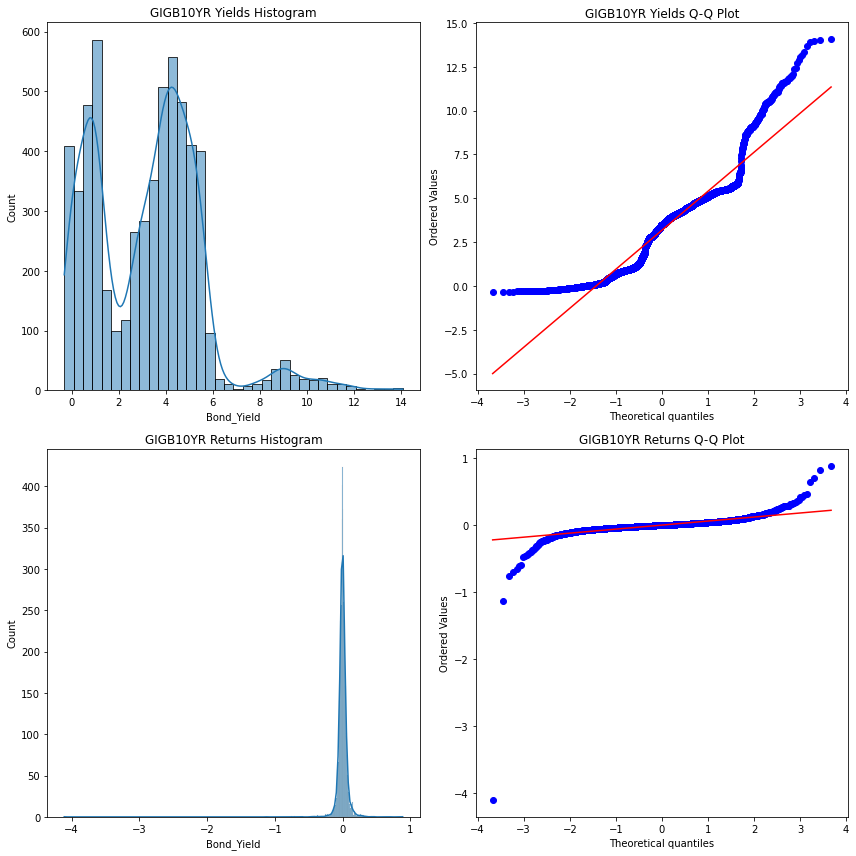

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


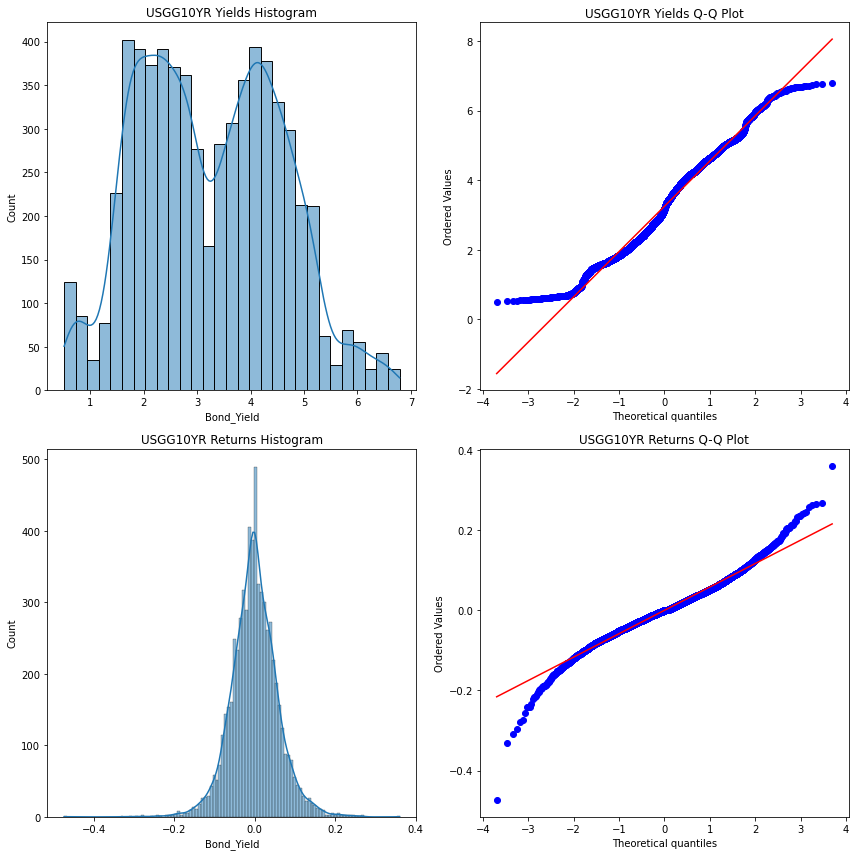

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


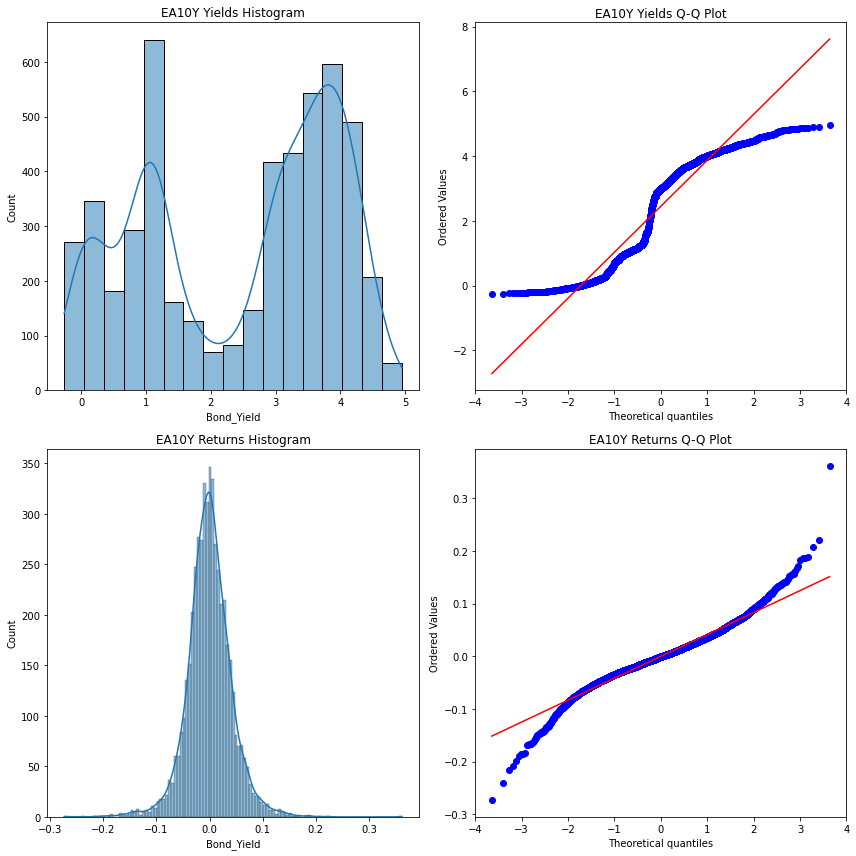

Normality test results for GDBR10:
  Shapiro-Wilk test for yields: ShapiroResult(statistic=0.9378397464752197, pvalue=1.401298464324817e-45)
  Shapiro-Wilk test for returns: ShapiroResult(statistic=0.9753611087799072, pvalue=9.282321116374139e-32)
  Kolmogorov-Smirnov test for yields: KstestResult(statistic=0.10651208981713173, pvalue=2.643550255143747e-63)
  Kolmogorov-Smirnov test for returns: KstestResult(statistic=0.05017758197149691, pvalue=2.3343046783720434e-14)


Normality test results for GTFRF10Y:
  Shapiro-Wilk test for yields: ShapiroResult(statistic=0.9400198459625244, pvalue=5.605193857299268e-45)
  Shapiro-Wilk test for returns: ShapiroResult(statistic=0.9706965684890747, pvalue=3.93213237761121e-34)
  Kolmogorov-Smirnov test for yields: KstestResult(statistic=0.11599948452284858, pvalue=5.5960837335630325e-75)
  Kolmogorov-Smirnov test for returns: KstestResult(statistic=0.052679203088905835, pvalue=9.04086931132227e-16)


Normality test results for GTNLG10Y:
  Shapiro-

In [137]:
# Ensure the DataFrame has the correct format and clean data
data.columns = ['Country', 'Date', 'Bond_Yield']
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.dropna(subset=['Date'], inplace=True)

# Filter the DataFrame to keep only 10-year maturities
ten_year_maturities = ['GDBR10', 'GTFRF10Y', 'GTNLG10Y', 'GTATS10Y', 'GTFIM10Y', 'GTBEF10Y', 'GBTPGR10', 'GTESP10Y', 'GTPTE10Y', 'GIGB10YR', 'USGG10YR', 'EA10Y']
data_10y = data[data['Country'].isin(ten_year_maturities)]

# Initialize a dictionary to store results
normality_results_10y = {}

# Loop through each 10-year maturity for each country
for country in ten_year_maturities:
    country_data = data_10y[data_10y['Country'] == country]
    yields = country_data['Bond_Yield'].dropna().astype(float)
    returns = yields.diff().dropna()
    
    # Shapiro-Wilk test for yields and returns
    shapiro_yields = shapiro(yields)
    shapiro_returns = shapiro(returns)
    
    # Kolmogorov-Smirnov test for yields and returns
    ks_yields = kstest(yields, 'norm', args=(yields.mean(), yields.std()))
    ks_returns = kstest(returns, 'norm', args=(returns.mean(), returns.std()))
    
    # Store results
    normality_results_10y[country] = {
        'Shapiro_Yields': shapiro_yields,
        'Shapiro_Returns': shapiro_returns,
        'KS_Yields': ks_yields,
        'KS_Returns': ks_returns
    }

    # Plotting
    plt.figure(figsize=(12, 12))

    # Histogram for yields
    plt.subplot(2, 2, 1)
    sns.histplot(yields, kde=True)
    plt.title(f'{country} Yields Histogram')

    # Q-Q plot for yields
    plt.subplot(2, 2, 2)
    probplot(yields, dist="norm", plot=plt)
    plt.title(f'{country} Yields Q-Q Plot')

    # Histogram for returns
    plt.subplot(2, 2, 3)
    sns.histplot(returns, kde=True)
    plt.title(f'{country} Returns Histogram')

    # Q-Q plot for returns
    plt.subplot(2, 2, 4)
    probplot(returns, dist="norm", plot=plt)
    plt.title(f'{country} Returns Q-Q Plot')

    plt.tight_layout()
    plt.show()

# Print a summary of the normality test results
for key, value in normality_results_10y.items():
    print(f"Normality test results for {key}:")
    print(f"  Shapiro-Wilk test for yields: {value['Shapiro_Yields']}")
    print(f"  Shapiro-Wilk test for returns: {value['Shapiro_Returns']}")
    print(f"  Kolmogorov-Smirnov test for yields: {value['KS_Yields']}")
    print(f"  Kolmogorov-Smirnov test for returns: {value['KS_Returns']}")
    print("\n")

## Log returns

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


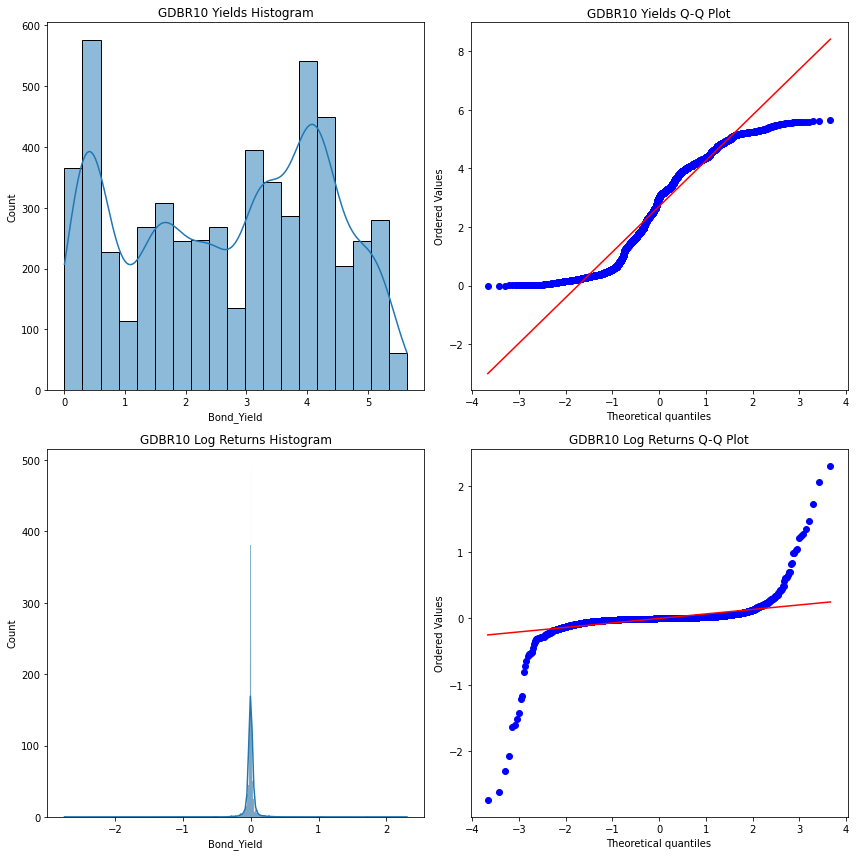

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


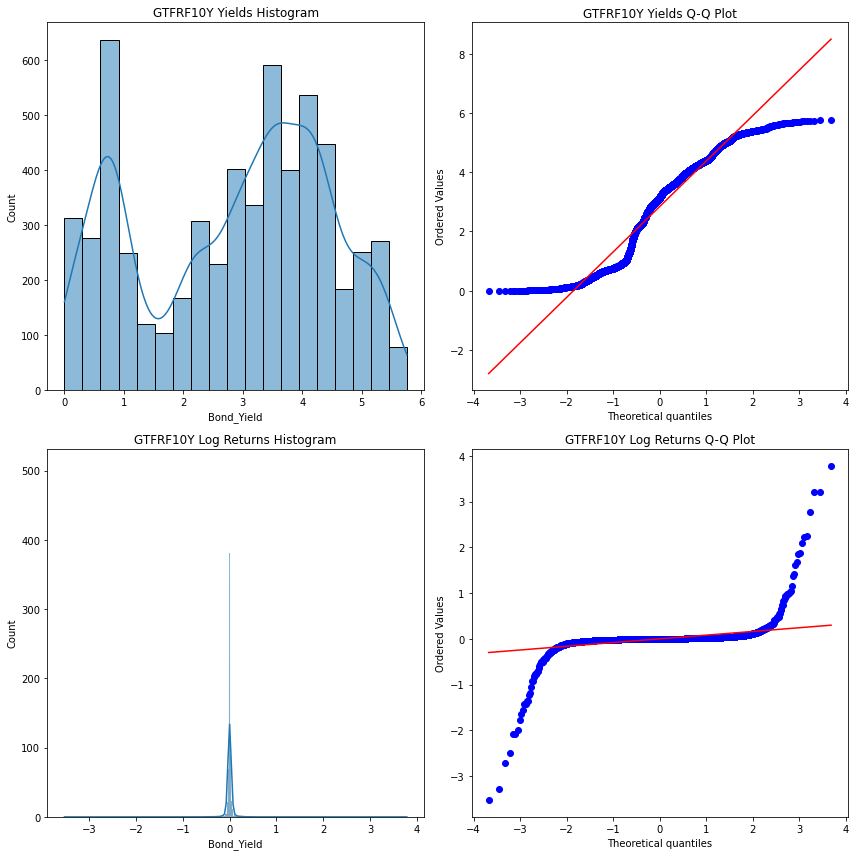

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


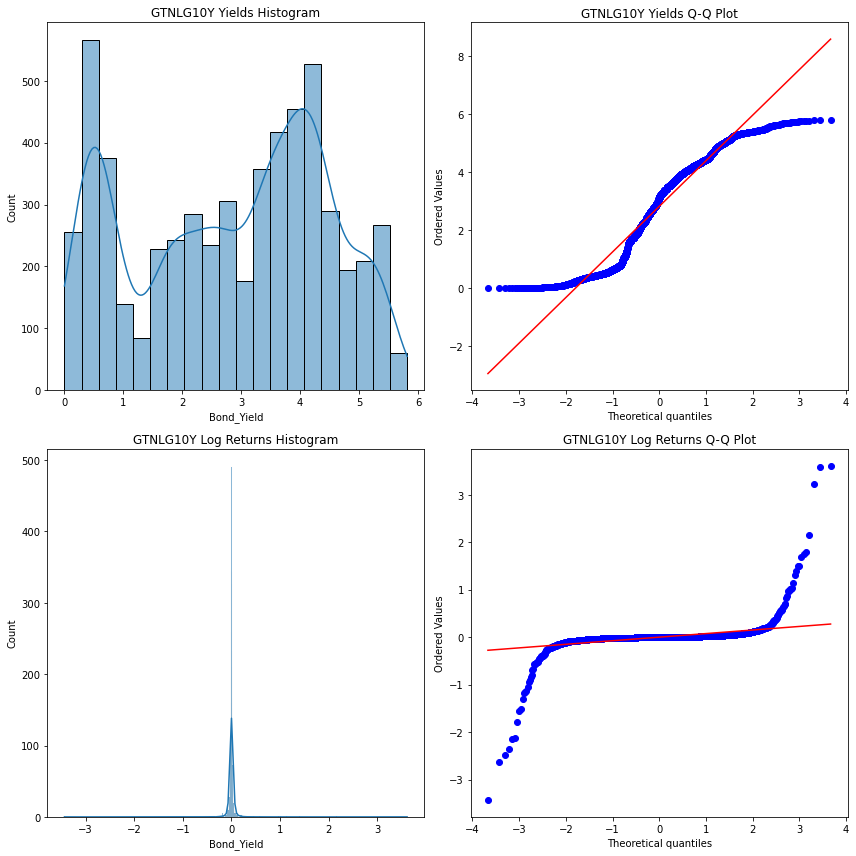

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


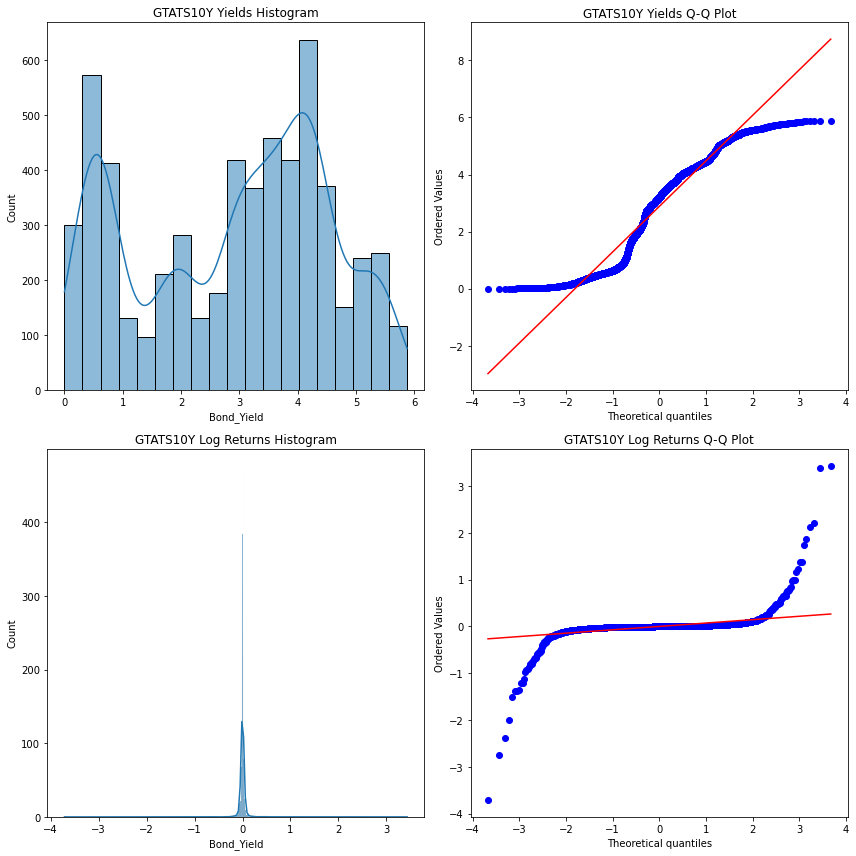

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


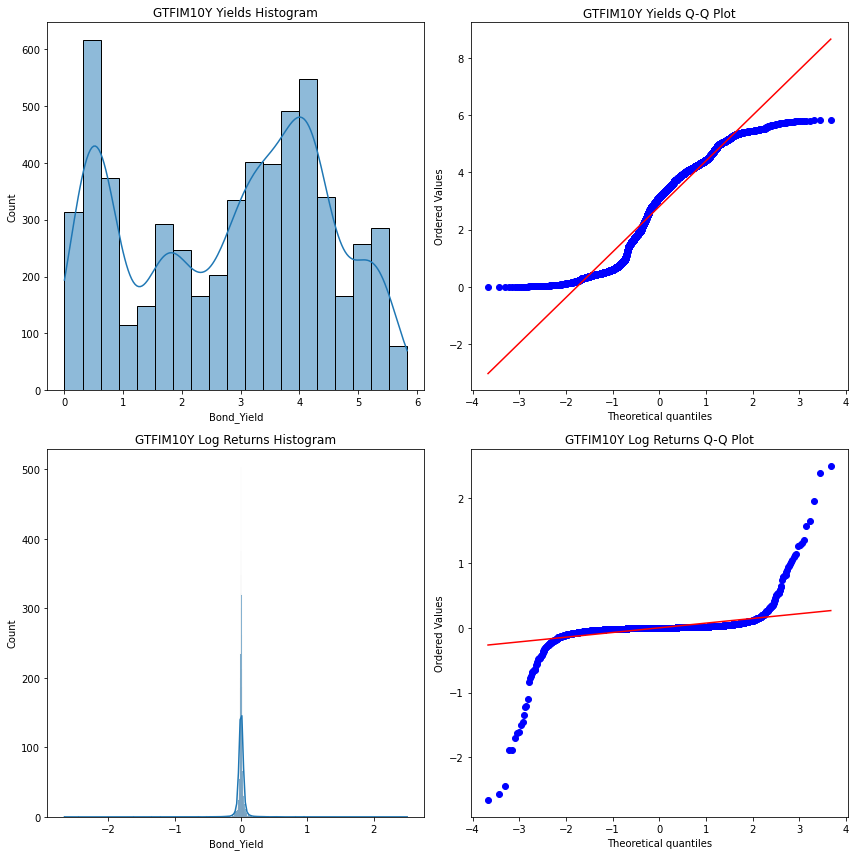

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


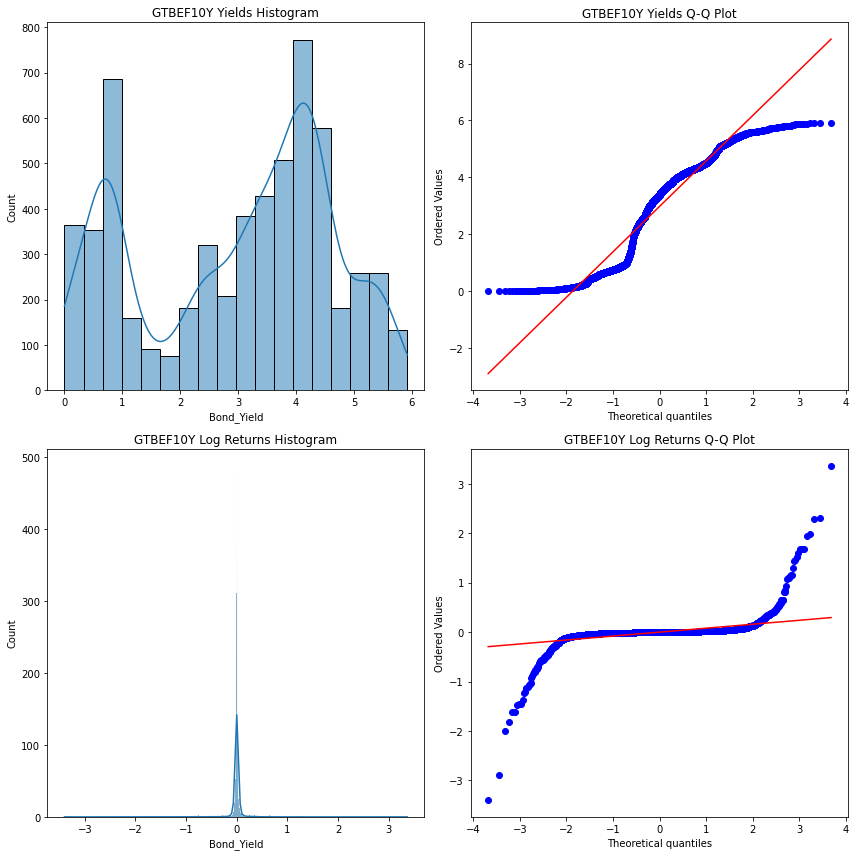

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


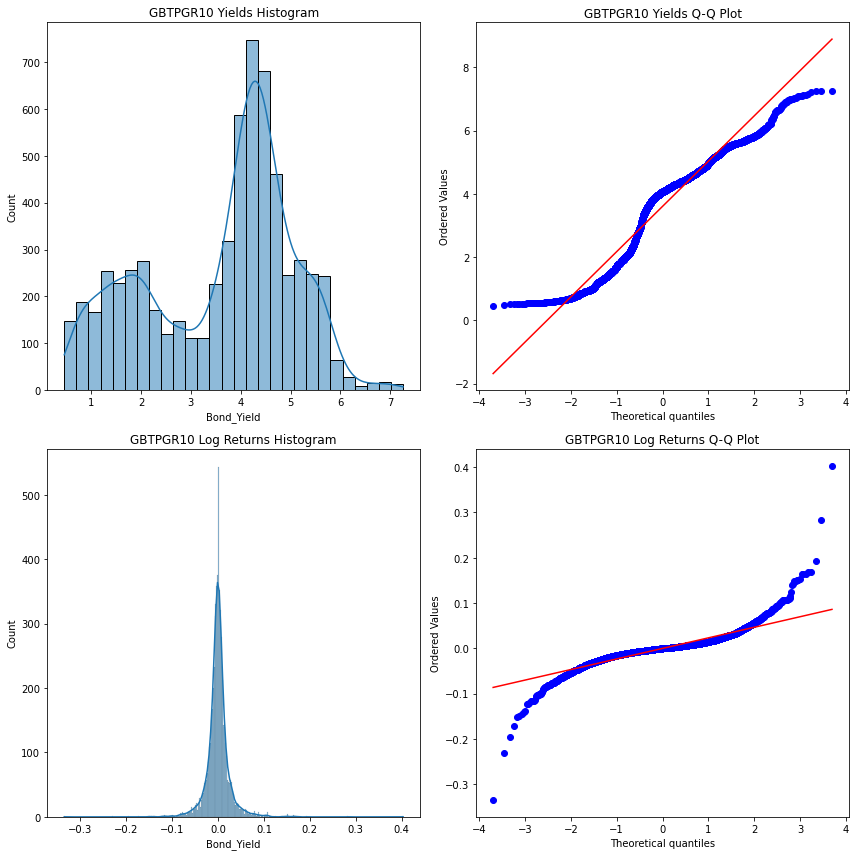

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


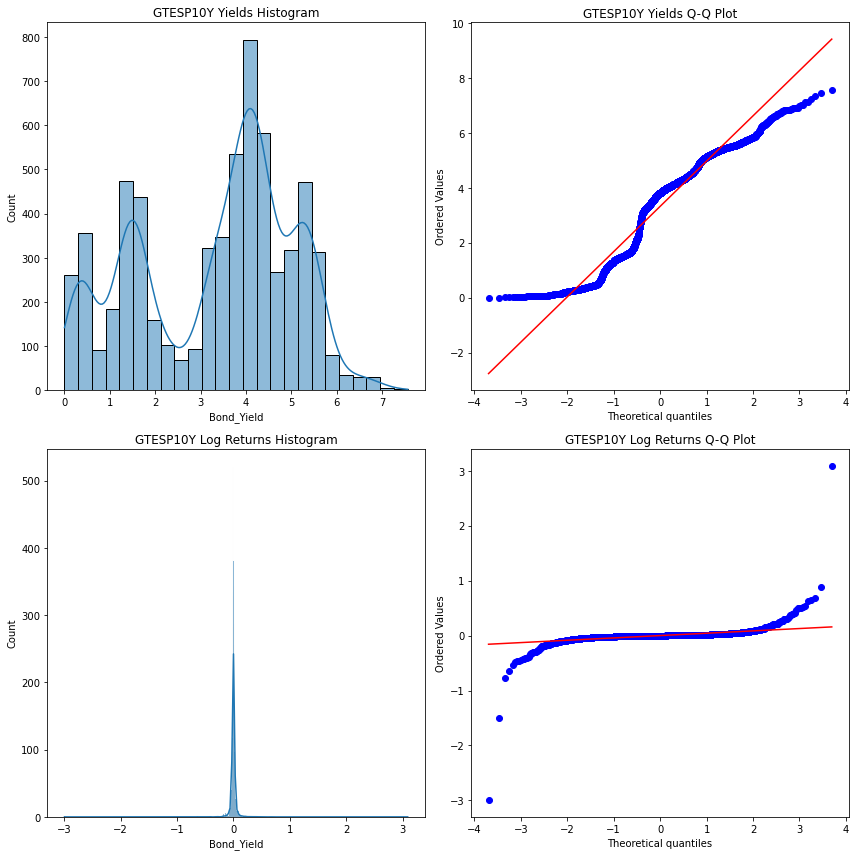

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


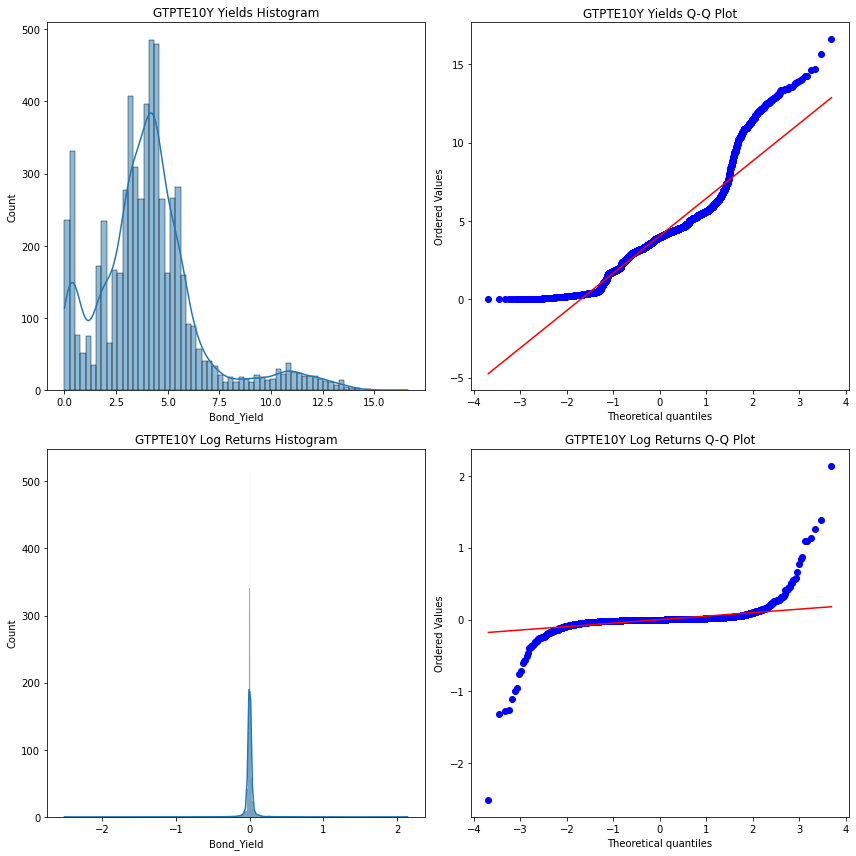

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


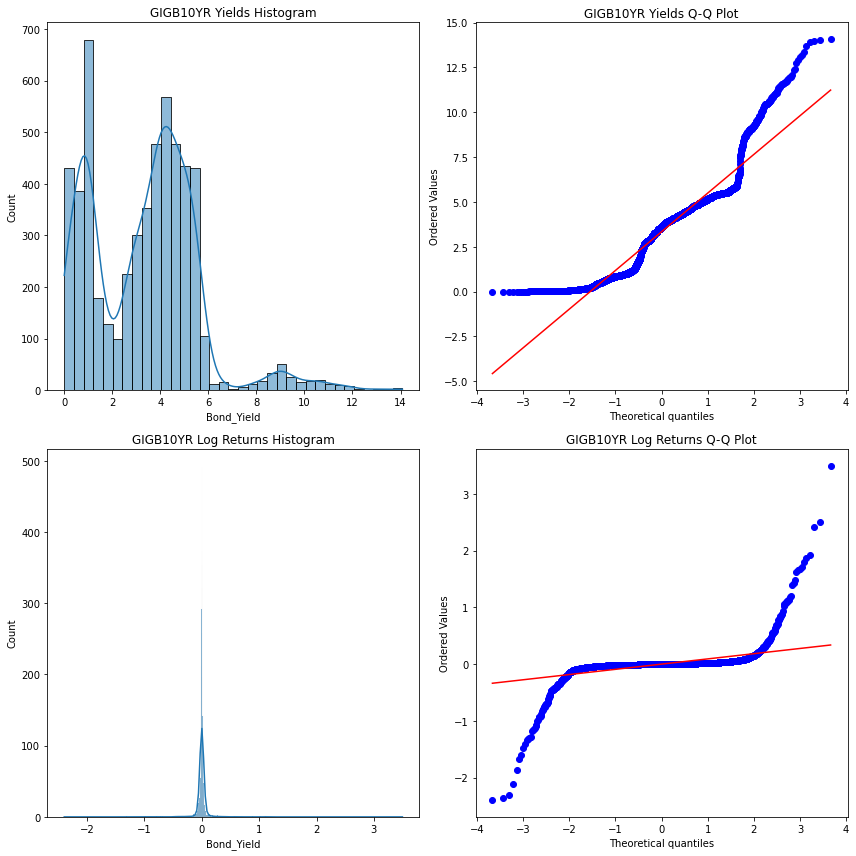

c:\Users\admin\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


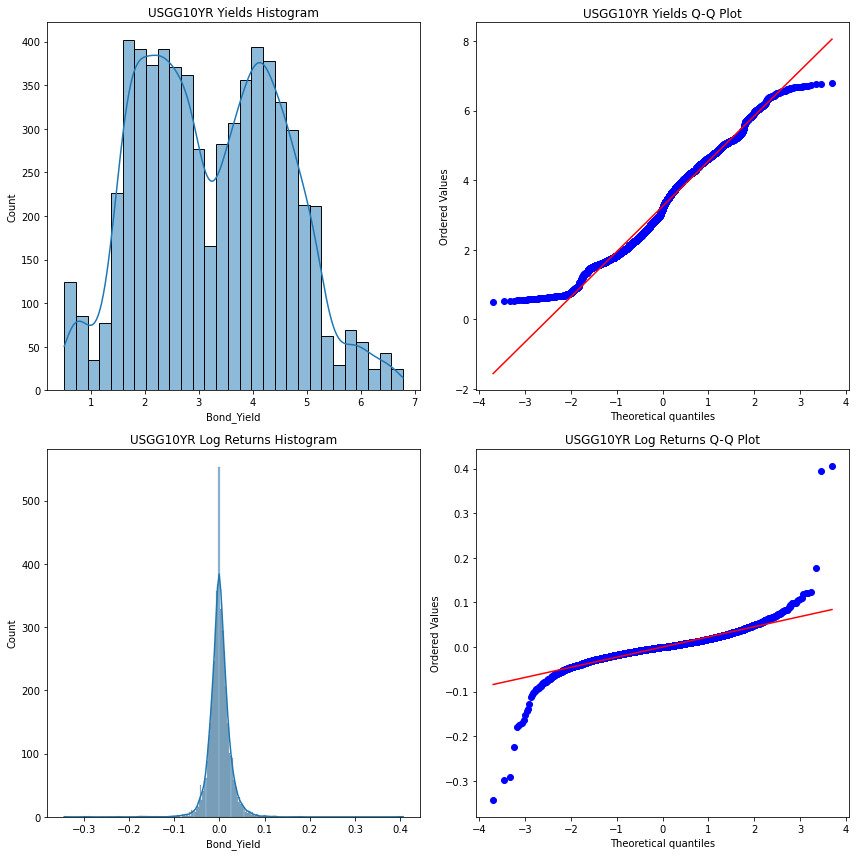

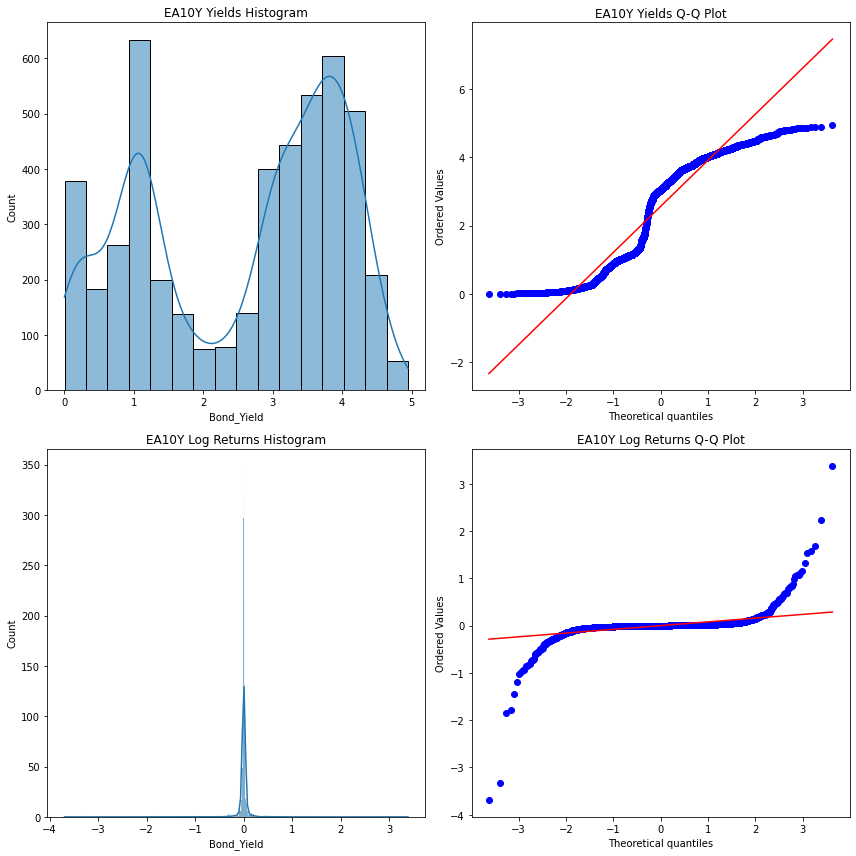

Normality test results for GDBR10:
  Shapiro-Wilk test for yields: ShapiroResult(statistic=0.9400054216384888, pvalue=9.921193127419705e-43)
  Shapiro-Wilk test for log returns: ShapiroResult(statistic=0.30395859479904175, pvalue=0.0)
  Kolmogorov-Smirnov test for yields: KstestResult(statistic=0.08549944949065746, pvalue=8.016889096708968e-36)
  Kolmogorov-Smirnov test for log returns: KstestResult(statistic=0.2944278064472674, pvalue=0.0)


Normality test results for GTFRF10Y:
  Shapiro-Wilk test for yields: ShapiroResult(statistic=0.9426903128623962, pvalue=5.226843271931568e-43)
  Shapiro-Wilk test for log returns: ShapiroResult(statistic=0.21871119737625122, pvalue=0.0)
  Kolmogorov-Smirnov test for yields: KstestResult(statistic=0.11036971520325617, pvalue=3.6176455888866886e-63)
  Kolmogorov-Smirnov test for log returns: KstestResult(statistic=0.3434133867974912, pvalue=0.0)


Normality test results for GTNLG10Y:
  Shapiro-Wilk test for yields: ShapiroResult(statistic=0.94209218

In [139]:
# Initialize a dictionary to store results
normality_results_10y = {}

# Loop through each 10-year maturity for each country
for country in ten_year_maturities:
    country_data = data_10y[data_10y['Country'] == country]
    yields = country_data['Bond_Yield'].dropna().astype(float)

    # Filter out non-positive values before taking the logarithm
    yields = yields[yields > 0]
    log_returns = np.log(yields).diff().dropna()
    
    # Shapiro-Wilk test for yields and log returns
    shapiro_yields = shapiro(yields)
    shapiro_log_returns = shapiro(log_returns)
    
    # Kolmogorov-Smirnov test for yields and log returns
    ks_yields = kstest(yields, 'norm', args=(yields.mean(), yields.std()))
    ks_log_returns = kstest(log_returns, 'norm', args=(log_returns.mean(), log_returns.std()))
    
    # Store results
    normality_results_10y[country] = {
        'Shapiro_Yields': shapiro_yields,
        'Shapiro_Log_Returns': shapiro_log_returns,
        'KS_Yields': ks_yields,
        'KS_Log_Returns': ks_log_returns
    }

    # Plotting
    plt.figure(figsize=(12, 12))

    # Histogram for yields
    plt.subplot(2, 2, 1)
    sns.histplot(yields, kde=True)
    plt.title(f'{country} Yields Histogram')

    # Q-Q plot for yields
    plt.subplot(2, 2, 2)
    probplot(yields, dist="norm", plot=plt)
    plt.title(f'{country} Yields Q-Q Plot')

    # Histogram for log returns
    plt.subplot(2, 2, 3)
    sns.histplot(log_returns, kde=True)
    plt.title(f'{country} Log Returns Histogram')

    # Q-Q plot for log returns
    plt.subplot(2, 2, 4)
    probplot(log_returns, dist="norm", plot=plt)
    plt.title(f'{country} Log Returns Q-Q Plot')

    plt.tight_layout()
    plt.show()

# Print a summary of the normality test results
for key, value in normality_results_10y.items():
    print(f"Normality test results for {key}:")
    print(f"  Shapiro-Wilk test for yields: {value['Shapiro_Yields']}")
    print(f"  Shapiro-Wilk test for log returns: {value['Shapiro_Log_Returns']}")
    print(f"  Kolmogorov-Smirnov test for yields: {value['KS_Yields']}")
    print(f"  Kolmogorov-Smirnov test for log returns: {value['KS_Log_Returns']}")
    print("\n")